# AI Data Analysis for Atoms-Clicker Game Optimization

The objective of this AI agent is to learn to play the "atoms-clicker" game in the most optimized way possible. Our AI model’s reward system, evaluated at each step, combines two factors: the automated atoms generated per second (heavily weighted) and the current atoms count. The AI aims to maximize this reward by learning to choose the best actions in each game state.

In this notebook, we’ll analyze the performance and behavior of the AI agent using data collected during model training. We have four key datasets:

- **`actions.csv`**: Details each step of the agent's interaction, including the state (automated atoms per second, current atoms count, available actions), the chosen action, and the reward obtained.
- **`memory.csv`**: Tracks the agent's experience replay memory, storing each state, action, reward, and next state, with states represented as NumPy arrays.
- **`training.csv`**: Logs training metrics such as duration per iteration, memory sample count, and loss values over time.
- **`finals.csv`**: Summarizes the end-state metrics for each trained agent, including total time spent in the game, total actions taken, final memory size, atoms count, and automated atoms per second.

Using these datasets, we’ll explore trends in the agent's decision-making process, learning progression, and overall performance in the game.

### Load dataframes

In [16]:
import ast

import pandas as pd

# Load the CSV file into a DataFrame
actions_df = pd.read_csv("training/actions.csv")
finals_df = pd.read_csv("training/finals.csv")

# Parse the 'available_actions' column as a list of strings
actions_df['available_actions'] = actions_df['available_actions'].apply(ast.literal_eval)

# print min-max values of reward when chosen_action is "click_center"
click_center_rewards = actions_df[actions_df['chosen_action'] == 'click_center']['reward']
print(f"Min/max reward for click_center: {click_center_rewards.min()} / {click_center_rewards.max()}")

# Preview the DataFrame
actions_df.head()

Min/max reward for click_center: 0.002 / 0.082


,uuid,relative_timestamp,atoms_count,rate_per_sec,available_actions,chosen_action,reward
0,c19ddaa2d41144d5bddcf957fba23bde,0.000000,0,0.0,"[wait, click_center]",click_center,0.002
1,c19ddaa2d41144d5bddcf957fba23bde,0.382425,1,0.0,"[wait, click_center]",wait,0.000
2,c19ddaa2d41144d5bddcf957fba23bde,0.793196,1,0.0,"[wait, click_center]",click_center,0.002
3,c19ddaa2d41144d5bddcf957fba23bde,1.182075,2,0.0,"[wait, click_center]",wait,0.000
4,c19ddaa2d41144d5bddcf957fba23bde,1.572458,2,0.0,"[wait, click_center]",wait,0.000


### Plot chosen actions data

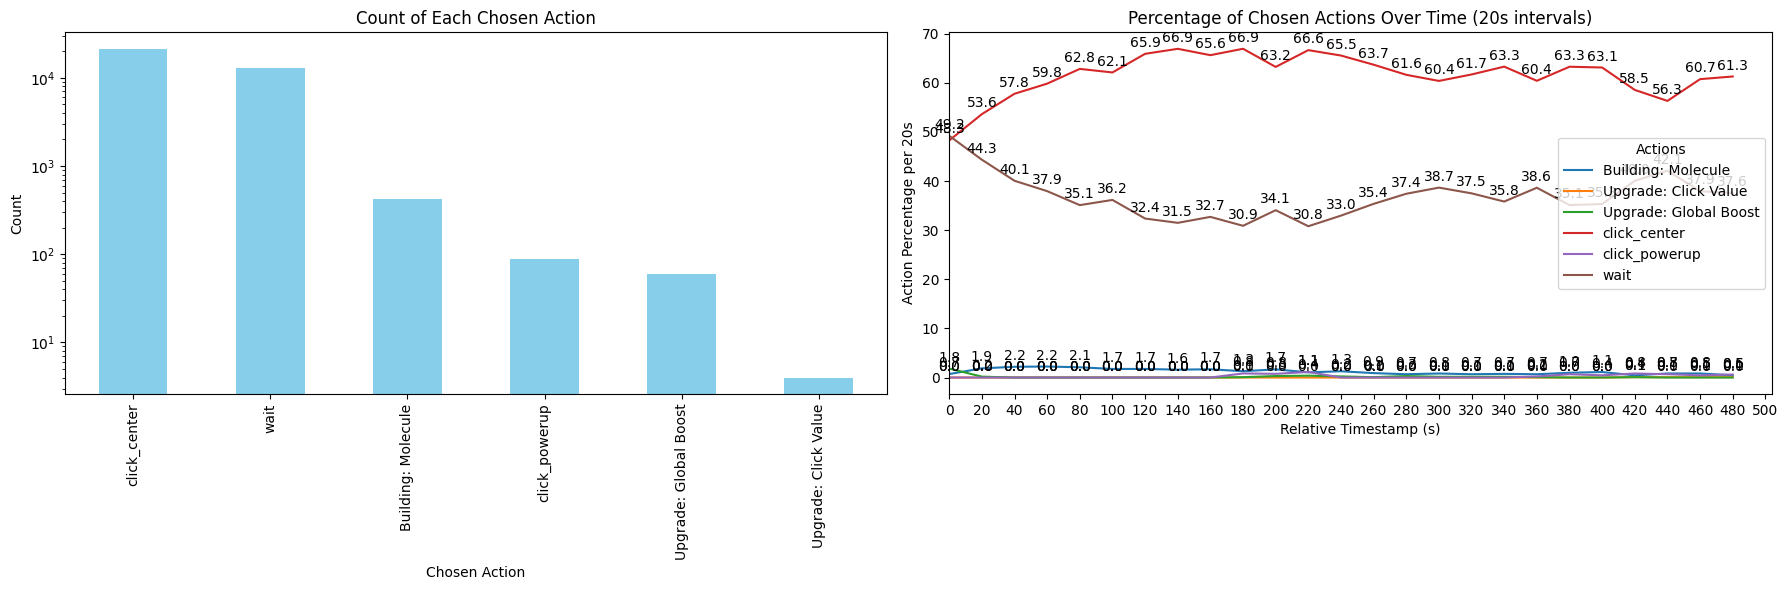

In [17]:
import matplotlib.pyplot as plt
from matplotlib import ticker


def plot_action_distribution():
    # Set up a 1x2 grid for side-by-side plots
    plt.figure(figsize=(18, 6))

    # Count the occurrences of each chosen_action for the bar graph
    action_counts = actions_df['chosen_action'].value_counts()

    # Plot 1: Bar graph of action counts
    plt.subplot(1, 2, 1)
    action_counts.plot(kind='bar', color='skyblue')
    plt.yscale('log')
    plt.title('Count of Each Chosen Action')
    plt.xlabel('Chosen Action')
    plt.ylabel('Count')

    # Group actions by X-second intervals and count them
    BIN_SIZE = 20
    actions_df['time_bin'] = (actions_df['relative_timestamp'] // BIN_SIZE) * BIN_SIZE
    actions_binned = actions_df.groupby(['time_bin', 'chosen_action']).size().unstack(fill_value=0)
    # Filter intervals where the sum of shares is <= 10
    average_count = actions_binned.sum(axis=1).mean() # type: ignore
    dynamic_threshold = 0.05 * average_count  # 5% de la moyenne
    actions_binned = actions_binned[actions_binned.sum(axis=1) > dynamic_threshold] # type: ignore
    # Convert counts to percentages for filtered intervals
    actions_binned = actions_binned.div(actions_binned.sum(axis=1), axis=0) * 100 # type: ignore

    # Plot 2: Line plot of cumulative chosen actions over time
    plt.subplot(1, 2, 2)
    for action in actions_binned.columns:
        plt.plot(actions_binned.index, actions_binned[action], label=action)
        for x,y in actions_binned[action].items():
            plt.annotate(f"{y:.1f}", (x, y), textcoords="offset points", xytext=(0, 5), ha="center") # type: ignore

    plt.title(f'Percentage of Chosen Actions Over Time ({BIN_SIZE}s intervals)')
    plt.xlabel('Relative Timestamp (s)')
    plt.ylabel(f'Action Percentage per {BIN_SIZE}s')
    plt.legend(title="Actions")
    plt.gca().set_xlim(left=0)
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(BIN_SIZE))

    # Show both plots
    plt.tight_layout()
    plt.show()

plot_action_distribution()

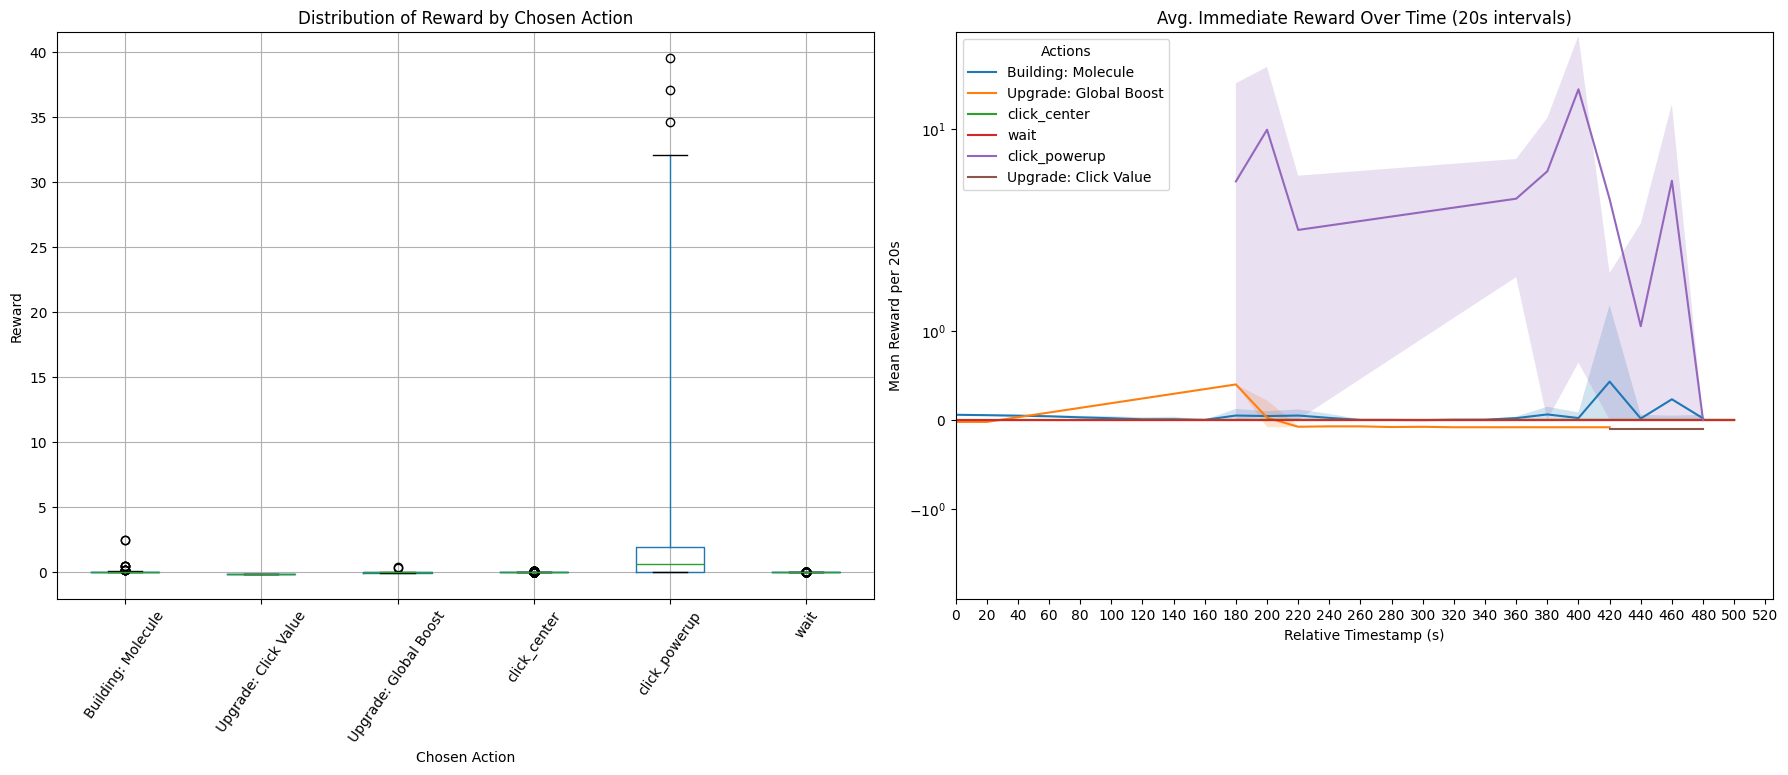

In [18]:
import matplotlib.pyplot as plt
from matplotlib import ticker
from numpy import percentile


def plot_reward_distribution():
    # Set up a 1x2 grid for side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot 1: Boxplot of reward distribution by chosen action
    actions_df.boxplot(column='reward', by='chosen_action', whis=(3, 97), grid=True, ax=axes[0])
    axes[0].set_title('Distribution of Reward by Chosen Action')
    fig.suptitle('')  # Suppress the default title to avoid overlap
    axes[0].set_xlabel('Chosen Action')
    axes[0].set_ylabel('Reward')
    axes[0].tick_params(axis='x', rotation=55)

    # Group rewards by X-second intervals and calculate mean and std
    BIN_SIZE = 20
    actions_df['time_bin'] = (actions_df['relative_timestamp'] // BIN_SIZE) * BIN_SIZE
    rewards_binned = actions_df.groupby(['time_bin', 'chosen_action'])['reward'].agg(
        mean='mean',
        p10=lambda x: percentile(x, 10),
        p90=lambda x: percentile(x, 90)
    ).reset_index()

    # Plot 2: Line plot of mean reward over time
    for action in rewards_binned['chosen_action'].unique():
        action_data = rewards_binned[rewards_binned['chosen_action'] == action]
        axes[1].plot(action_data['time_bin'], action_data['mean'], label=action)
        axes[1].fill_between(
            action_data['time_bin'],
            action_data['p10'], 
            action_data['p90'], 
            alpha=0.2
        )

    axes[1].set_title(f'Avg. Immediate Reward Over Time ({BIN_SIZE}s intervals)')
    axes[1].set_xlabel('Relative Timestamp (s)')
    axes[1].set_xlim(left=0)
    axes[1].set_ylabel(f'Mean Reward per {BIN_SIZE}s')
    plt.yscale('symlog')
    axes[1].legend(title="Actions")
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(BIN_SIZE))

    # Show both plots
    plt.tight_layout()
    plt.show()


plot_reward_distribution()

In [19]:
# Get the most rewarding actions
filtered_df = actions_df[actions_df['chosen_action'] == "Building: Molecule"]
actions_df.sort_values(by='reward', ascending=True).head(15)

,uuid,relative_timestamp,atoms_count,rate_per_sec,available_actions,chosen_action,reward,time_bin
28650,2d576294813e4a0490cd920bc531ea85,455.367726,254,1.65,"[wait, click_center, build_0, upgrade_0]",Upgrade: Click Value,-0.10,440.0
22121,0d711ea4cff24b54b62564e0dc122fef,422.694715,292,1.55,"[wait, click_center, build_0, upgrade_0]",Upgrade: Click Value,-0.10,420.0
27407,6ac9f0026112443c8bd9551ddbb922ee,473.570300,263,2.47,"[wait, click_center, build_0, upgrade_0]",Upgrade: Click Value,-0.10,460.0
33899,12da52f417af42e89be11778a0503aff,494.730506,250,1.75,"[wait, click_center, build_0, upgrade_0]",Upgrade: Click Value,-0.10,480.0
6242,999edd05e4ce4f3fa5d69b782d62ca4c,362.091969,100,1.11,"[wait, click_center, upgrade_0]",Upgrade: Global Boost,-0.08,360.0
16961,973af97aab17439092760afa9b481131,429.614714,102,1.11,"[wait, click_center, build_0, upgrade_0]",Upgrade: Global Boost,-0.08,420.0
24129,89d9e97f4d884f48bbe28480f110d05a,205.420036,101,1.11,"[wait, click_center, upgrade_0]",Upgrade: Global Boost,-0.08,200.0
26774,6ac9f0026112443c8bd9551ddbb922ee,227.980474,100,1.11,"[wait, click_center, upgrade_0]",Upgrade: Global Boost,-0.08,220.0
21582,0d711ea4cff24b54b62564e0dc122fef,212.602241,108,1.01,"[wait, click_center, build_0, upgrade_0]",Upgrade: Global Boost,-0.08,200.0
2243,d0672f69ed9242ea964d3c7a1e65348d,300.579582,100,1.11,"[wait, click_center, upgrade_0]",Upgrade: Global Boost,-0.08,300.0


### Plot final results

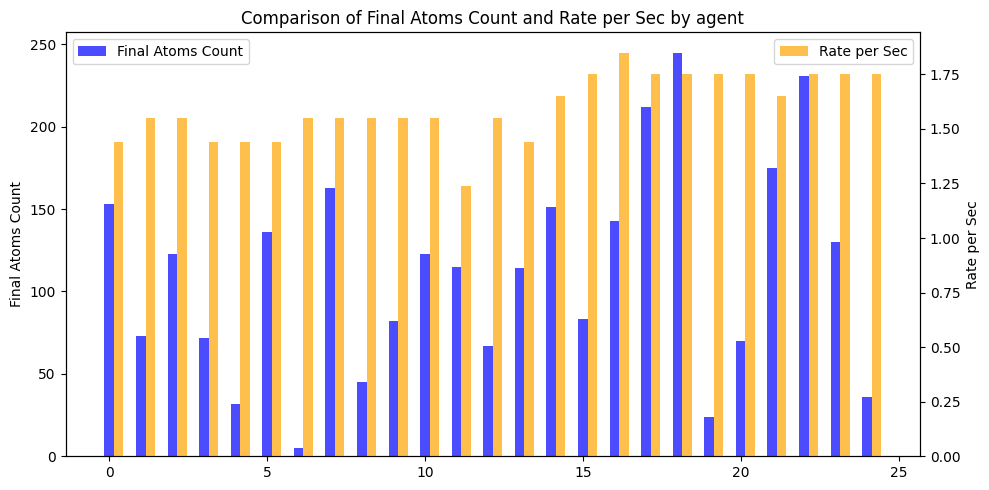

In [20]:
import matplotlib.pyplot as plt


def plot_final_comparison():
    MIN_DURATION = 300
    filtered_df = finals_df[finals_df['time_spent'] >= MIN_DURATION]

    plt.figure(figsize=(10, 5))
    x = range(len(filtered_df))
    width = 0.3

    plt.bar(
        x,
        filtered_df['atoms_count'],
        width=width, label='Final Atoms Count', color='blue', alpha=0.7
    )
    plt.ylabel("Final Atoms Count")
    plt.legend(loc='upper left')
    
    ax1 = plt.twinx()
    ax1.bar( # type: ignore
        [i + width for i in x],
        filtered_df['rate_per_sec'],
        width=width, label='Rate per Sec', color='orange', alpha=0.7
    )
    ax1.set_ylabel("Rate per Sec")
    ax1.legend(loc='upper right') # type: ignore

    plt.title('Comparison of Final Atoms Count and Rate per Sec by agent')
    plt.tight_layout()
    plt.show()

plot_final_comparison()

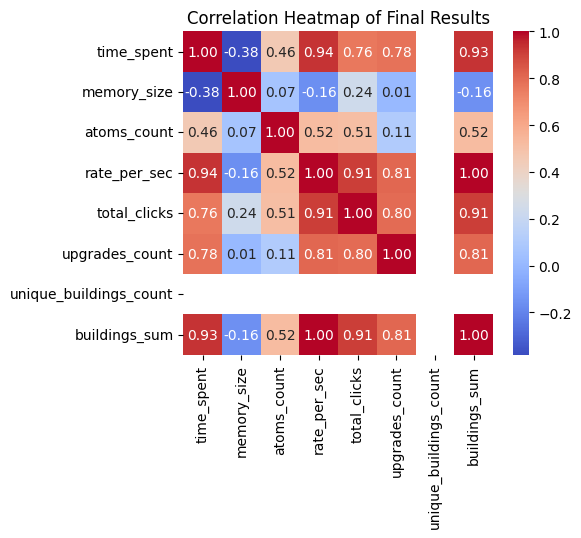

In [21]:
import seaborn as sns


def plot_correlation_heatmap():
    plt.figure(figsize=(5, 4.2))
    sns.heatmap(
        finals_df.drop(columns=['uuid', 'timestamp', 'steps_count', 'max_building']).corr(),
        annot=True, cmap='coolwarm', fmt='.2f'
    )
    plt.title('Correlation Heatmap of Final Results')
    plt.show()

plot_correlation_heatmap()